# Deep Neural Network for Image Classification: Application


In [88]:
import time

import h5py
import matplotlib.pyplot as plt
import numpy as np
import scipy
import torch
from dnn_utils import load_data
from PIL import Image
from scipy import ndimage
from torch import nn

%matplotlib inline
plt.rcParams["figure.figsize"] = (5.0, 4.0)  # set default size of plots
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2 - Load and Process the Dataset


In [89]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

y = tensor(0.). It's a non-cat picture.


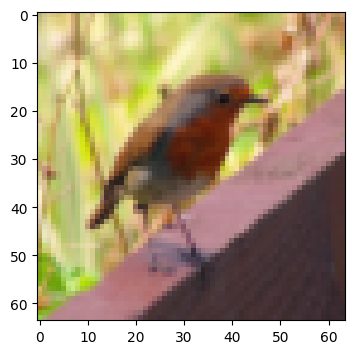

In [90]:
# Example of a picture
index = 10
plt.imshow(train_x_orig[index])
print(
    "y = "
    + str(train_y[index, 0])
    + ". It's a "
    + classes[int(train_y[index, 0])].decode("utf-8")
    + " picture."
)

In [91]:
# Explore your dataset
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print("Number of training examples: " + str(m_train))
print("Number of testing examples: " + str(m_test))
print("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print("train_x_orig shape: " + str(train_x_orig.shape))
print("train_y shape: " + str(train_y.shape))
print("test_x_orig shape: " + str(test_x_orig.shape))
print("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: torch.Size([209, 64, 64, 3])
train_y shape: torch.Size([209, 1])
test_x_orig shape: torch.Size([50, 64, 64, 3])
test_y shape: torch.Size([50, 1])


### Reshape and standardize


In [92]:
train_x_flatten = train_x_orig.flatten(start_dim=1)
test_x_flatten = test_x_orig.flatten(start_dim=1)

train_x = train_x_flatten / 255.0
test_x = test_x_flatten / 255.0

print(train_x.shape)
print(test_x.shape)

torch.Size([209, 12288])
torch.Size([50, 12288])


## Two-layer Neural Network


In [93]:
n_x = train_x.shape[1]  # 12288
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)
learning_rate = 0.075

In [27]:
def two_layer_model(
    X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False
):
    (n_x, n_h, n_y) = layers_dims

    model = nn.Sequential(
        nn.Linear(n_x, n_h), nn.ReLU(), nn.Linear(n_h, n_y), nn.Sigmoid()
    )

    optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate)

    compute_cost = nn.BCELoss()

    costs = []

    for i in range(num_iterations):
        optimizer.zero_grad()

        y_pred = model(X)

        cost = compute_cost(y_pred, Y)

        cost.backward()

        optimizer.step()

        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, cost.item()))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost.item())

    return model, costs

In [28]:
def plot_costs(costs, learning_rate=0.0075):
    plt.plot(costs)
    plt.ylabel("cost")
    plt.xlabel("iterations (per hundreds)")
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

### Training


Cost after iteration 0: 0.7151604890823364
Cost after iteration 100: 0.6122652888298035
Cost after iteration 200: 0.5642291307449341
Cost after iteration 300: 0.5091351270675659
Cost after iteration 400: 0.45057302713394165
Cost after iteration 500: 0.4057376980781555
Cost after iteration 600: 0.3748442828655243
Cost after iteration 700: 0.345100462436676
Cost after iteration 800: 0.312185674905777
Cost after iteration 900: 0.280540406703949
Cost after iteration 1000: 0.23538239300251007
Cost after iteration 1100: 0.1667657494544983
Cost after iteration 1200: 0.13846929371356964
Cost after iteration 1300: 0.12467894703149796
Cost after iteration 1400: 0.13161979615688324
Cost after iteration 1500: 0.08845724165439606
Cost after iteration 1600: 0.07916685938835144
Cost after iteration 1700: 0.07149939984083176
Cost after iteration 1800: 0.06583594530820847
Cost after iteration 1900: 0.05990501120686531
Cost after iteration 2000: 0.05594850331544876
Cost after iteration 2100: 0.052723057

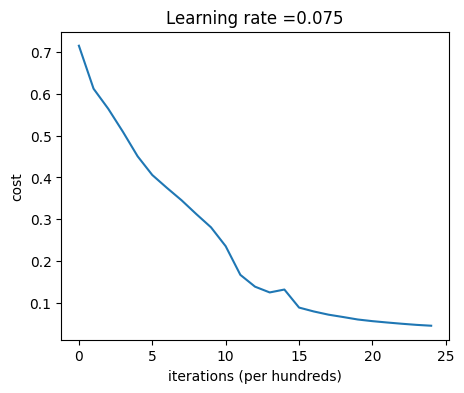

In [29]:
model, costs = two_layer_model(
    train_x,
    train_y,
    layers_dims=(n_x, n_h, n_y),
    num_iterations=2500,
    learning_rate=0.0075,
    print_cost=True,
)
plot_costs(costs, learning_rate)

In [66]:
def predict(X, y, model):
    probas = model(X)

    p = probas > 0.5

    print("Accuracy: " + str(torch.mean((p == y).to(torch.float)).item()))

    return p

In [35]:
predict(train_x, train_y, model)

Accuracy: 0.9904305934906006


In [36]:
predict(test_x, test_y, model)

Accuracy: 0.7200000286102295


## L-layer Neural Network


In [53]:
### CONSTANTS ###
layers_dims = [12288, 20, 7, 5, 1]  #  4-layer model

In [54]:
def L_layer_model(
    X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False
):
    layers = [
        layer
        for i in range(len(layers_dims) - 2)
        for layer in (nn.Linear(layers_dims[i], layers_dims[i + 1]), nn.ReLU())
    ]

    layers = layers + [nn.Linear(layers_dims[-2], layers_dims[-1]), nn.Sigmoid()]

    model = nn.Sequential(*layers)

    optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate)

    compute_cost = nn.BCELoss()

    costs = []

    for i in range(num_iterations):
        optimizer.zero_grad()

        y_pred = model(X)

        cost = compute_cost(y_pred, Y)

        cost.backward()

        optimizer.step()

        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, cost.item()))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost.item())

    return model, costs

In [60]:
model, costs = L_layer_model(
    train_x, train_y, layers_dims, num_iterations=2500, print_cost=True
)

Cost after iteration 0: 0.699744462966919
Cost after iteration 100: 0.6584606170654297
Cost after iteration 200: 0.6458550691604614
Cost after iteration 300: 0.6415813565254211
Cost after iteration 400: 0.6369866728782654
Cost after iteration 500: 0.6271057724952698
Cost after iteration 600: 0.5980205535888672
Cost after iteration 700: 0.5619442462921143
Cost after iteration 800: 0.5135767459869385
Cost after iteration 900: 0.4458233416080475
Cost after iteration 1000: 0.45175209641456604
Cost after iteration 1100: 0.42562445998191833
Cost after iteration 1200: 0.3924165964126587
Cost after iteration 1300: 0.3555057644844055
Cost after iteration 1400: 0.30686578154563904
Cost after iteration 1500: 0.2204081267118454
Cost after iteration 1600: 0.1879328489303589
Cost after iteration 1700: 0.07862372696399689
Cost after iteration 1800: 0.04775121808052063
Cost after iteration 1900: 0.031945809721946716
Cost after iteration 2000: 0.022794706746935844
Cost after iteration 2100: 0.017118366

In [61]:
predict(train_x, train_y, model)

Accuracy: 1.0


In [67]:
pred_test = predict(test_x, test_y, model)
# Accuracy may vary depending on params initialization

Accuracy: 0.7799999713897705


## 6 - Results Analysis


In [75]:
def print_mislabeled_images(classes, X, y, p):
    """
    Plots images where predictions and truth were different.
    X -- dataset
    y -- true labels
    p -- predictions
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams["figure.figsize"] = (40.0, 40.0)  # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]

        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:, index].reshape(64, 64, 3), interpolation="nearest")
        plt.axis("off")
        plt.title(
            "Prediction: "
            + classes[int(p[0, index])].decode("utf-8")
            + " \n Class: "
            + classes[int(y[0, index])].decode("utf-8")
        )

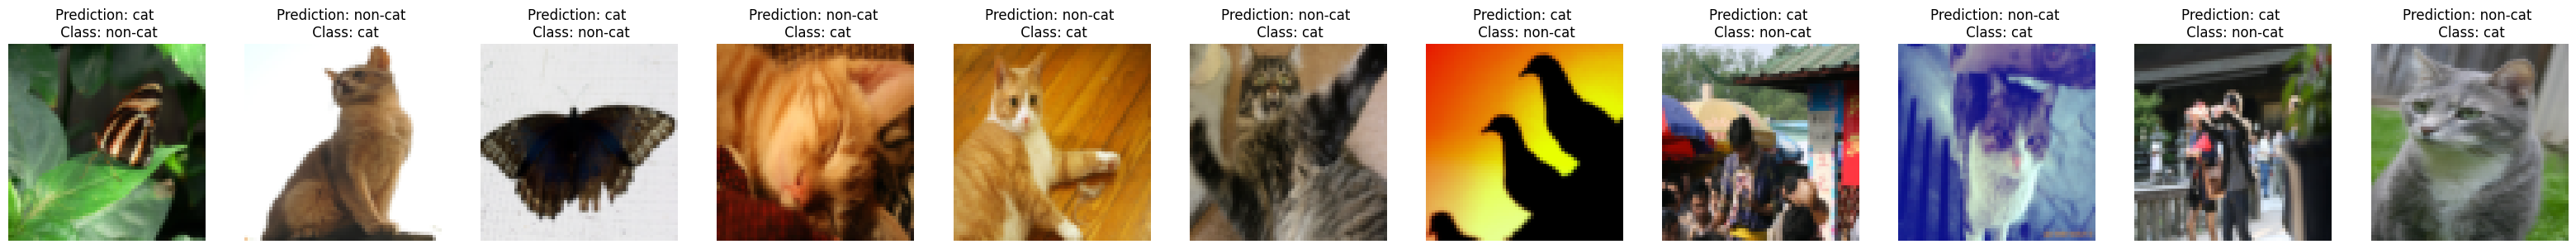

In [76]:
print_mislabeled_images(classes, test_x.T, test_y.T, pred_test.T)